In [49]:
import time
import numpy as np
import glob
import iris
import iris.coord_categorisation
import iris.analysis
import subprocess
import os
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy.ma as ma
import running_mean
from scipy import signal
import scipy
import scipy.stats
import numpy as np
import statsmodels.api as sm
import running_mean_post
from scipy.interpolate import interp1d
import scipy.stats as stats
import pandas as pd
import matplotlib.cm as mpl_cm
from matplotlib.patches import ConnectionPatch

In [50]:
import sys
sys.version

'2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, 21:00:58) \n[GCC 7.3.0]'

In [51]:
#this is a simple function that we call later to look at the file names and extarct from them a unique list of models to process
#note that the model name is in the filename when downlaode ddirectly from the CMIP5 archive
def model_names(directory,variable):
    files = glob.glob(directory+'/*'+variable+'*.nc')
    models_tmp = []
    for file in files:
        statinfo = os.stat(file)
        if statinfo.st_size >= 1:
            models_tmp.append(file.split('/')[-1].split('_')[0])
            models = np.unique(models_tmp)
    return models

In [52]:

def smoothed_correlations(a,b,smoothings1,smoothings2):
    a = scipy.signal.detrend(a)
    a /= np.nanstd(a)
    b = scipy.signal.detrend(b)
    b /= np.nanstd(b)
    coeff_det_a_b_sig= np.zeros([np.size(smoothings1),np.size(smoothings2)])
    coeff_det_a_b_sig[:] = np.NAN
    coeff_det_a_b_not_sig = coeff_det_a_b_sig.copy()
    for smoothing_no1,smoothing1 in enumerate(smoothings1):
            smoothing1 = np.int(smoothing1)
            print smoothing_no1,' out of ',np.size(smoothings1)
            window_type = 'boxcar'
            for smoothing_no2, smoothing2 in enumerate(smoothings2):
                    smoothing2 = np.int(smoothing2)
                    # x = pd.rolling_window(a.copy(),smoothing1,win_type=window_type,center=True)
                    # y = pd.rolling_window(b.copy(),smoothing2,win_type=window_type,center=True)
                    x = pd.DataFrame({'a':a.copy()}).rolling(smoothing1,win_type=window_type,center=True).sum().values
                    y = pd.DataFrame({'b':b.copy()}).rolling(smoothing2,win_type=window_type,center=True).sum().values
                    loc = np.where(np.logical_not(np.isnan(x) | np.isnan(y)))
                    x = x[loc]
                    y = y[loc]
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
                    r2 = r_value**2
                    coeff_det_a_b_sig[smoothing_no1,smoothing_no2] = r_value
                    if p_value > 0.001:
                            coeff_det_a_b_not_sig[smoothing_no1,smoothing_no2] = r_value
    return coeff_det_a_b_sig,coeff_det_a_b_not_sig

In [53]:
'''
#Main bit of code follows...
'''

#N Hem
lon_west1 = 0
lon_east1 = 360
lat_south1 = 0.0
lat_north1 = 90.0

#Atl sector of Arctic
lon_west1 = -45.0
lon_east1 = 25.0
lat_south1 = 0.0
lat_north1 = 90.0

region1 = iris.Constraint(longitude=lambda v: lon_west1 <= v <= lon_east1,latitude=lambda v: lat_south1 <= v <= lat_north1)


variables = np.array(['sic'])
#specify the temperal averaging period of the data in your files e.g for an ocean file 'Omon' (Ocean monthly) or 'Oyr' (ocean yearly). Atmosphere would be comething like 'Amon'. Note this just prevents probvlems if you accidently did not specify the time frequency when doenloading the data, so avoids trying to puut (e.g.) daily data and monthly data in the same file.


input_directory2 = '/data/NAS-ph290/ph290/cmip5/last1000/monthly/'

modelsb = model_names(input_directory2,variables[0])
modelsb = list(modelsb)
modelsb.remove('HadCM3') # just removing for now as now have HadGEM2-ES

cube1 = iris.load_cube(input_directory2+modelsb[0]+'*'+variables[0]+'*.nc')[0]

modelbs2 = []
cubes_n_hem = []
ts_n_hem = []

for model in modelsb:
    print 'processing: '+model
    try:
        cube = iris.load_cube(input_directory2+model+'*'+variables[0]+'*.nc')
    except:
        cube = iris.load(input_directory2+model+'*'+variables[0]+'*.nc')
        cube = cube[0]
    # iris.coord_categorisation.add_month(cube, 'time', name='month')
    # cube = cube[np.where(cube.coord('month').points == 'Mar')]
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    cube=cube[np.where((cube.coord('year').points >= 950) & (cube.coord('year').points < 1850))]
    # iris.coord_categorisation.add_season(cube, 'time', name='season')
    # iris.coord_categorisation.add_season_year(cube, 'time', name='season_year')
    # cube = cube.aggregated_by(['season_year','season'], iris.analysis.MEAN)
    # cube = cube[np.where(cube.coord('season').points == 'son')]
    cube = cube.aggregated_by(['year'], iris.analysis.MEAN)
    if model == ('MRI-CGCM3'):
        for i in range(cube.shape[0]):
            cube.data.mask[i] = cube1.data.mask
    tmp1 = cube.extract(region1)
    cubes_n_hem.append(tmp1)
    #qplt.contourf(tmp1[0])
    #plt.show()
    ts_n_hem.append(tmp1.collapsed(['latitude','longitude'],iris.analysis.MEAN))



# reynolds_file = '/home/ph290/data0/reynolds/ultra_data.csv'
reynolds_file = '/data/NAS-ph290/ph290/misc_data/raw_Iceland_isotope_data.csv'
reynolds_data = np.genfromtxt(reynolds_file,skip_header = 1,delimiter = ',')

tmp = np.shape(cubes_n_hem[0].data)
# tmp_data = np.ma.empty([np.size(cubes_n_hem),tmp[0],tmp[1],tmp[2]])
tmp_data = np.ma.empty([np.size(cubes_n_hem),900,tmp[1],tmp[2]])

for i in np.arange(np.size(cubes_n_hem)):
    tmp_data[i] = cubes_n_hem[i].data[0:900]



coord = ts_n_hem[0].coord('time')
dt = coord.units.num2date(coord.points)
year = np.array([coord.units.num2date(value).year for value in coord.points])



data = np.zeros([900,np.size(ts_n_hem)])
j=0
for i,ts in enumerate(ts_n_hem):
    print modelsb[i]
    data[:,j] = signal.detrend(ts.data[0:900])
    # data[:,j] = (ts.data[0:1000])
    j += 1

multimodel_mean = data.mean(axis = 1)
multimodel_max = data.max(axis = 1)
multimodel_min = data.min(axis = 1)





##########
# correlations
##########

reynolds_data2 = np.flipud(reynolds_data)
y = multimodel_mean-np.nanmean(multimodel_mean)
y /= np.std(y)

smoothings1 = range(1,150,2)
smoothings2 = smoothings1
year2 = year[0]+np.arange(900)


loc1 = np.where((year2 <= 1200) & (year2 >= 960) )[0]
loc2 = np.where((reynolds_data2[:,0] <= 1200) & (reynolds_data2[:,0] >= 960) )[0]

phase1_corr_sig,phase1_corr_not_sig = smoothed_correlations(y[loc1],reynolds_data2[loc2,2],smoothings1,smoothings2)

loc1 = np.where((year2 <= 1600) & (year2 >= 1200) )[0]
loc2 = np.where((reynolds_data2[:,0] <= 1600) & (reynolds_data2[:,0] >= 1200) )[0]

phase2_corr_sig,phase2_corr_not_sig = smoothed_correlations(y[loc1],reynolds_data2[loc2,2],smoothings1,smoothings2)

loc1 = np.where((year2 <= 1850) & (year2 >= 1600) )[0]
loc2 = np.where((reynolds_data2[:,0] <= 1849) & (reynolds_data2[:,0] >= 1600) )[0]

phase3_corr_sig,phase3_corr_not_sig = smoothed_correlations(y[loc1],reynolds_data2[loc2,2],smoothings1,smoothings2)

processing: CCSM4
processing: CSIRO-Mk3L-1-2
processing: GISS-E2-R
processing: HadGEM2-ES
processing: MIROC-ESM
processing: MPI-ESM-P
processing: MRI-CGCM3
processing: bcc-csm1-1
CCSM4
CSIRO-Mk3L-1-2
GISS-E2-R
HadGEM2-ES
MIROC-ESM
MPI-ESM-P
MRI-CGCM3
bcc-csm1-1
0  out of  75
1  out of  75
2  out of  75
3  out of  75
4  out of  75
5  out of  75
6  out of  75
7  out of  75
8  out of  75
9  out of  75
10  out of  75
11  out of  75
12  out of  75
13  out of  75
14  out of  75
15  out of  75
16  out of  75
17  out of  75
18  out of  75
19  out of  75
20  out of  75
21  out of  75
22  out of  75
23  out of  75
24  out of  75
25  out of  75
26  out of  75
27  out of  75
28  out of  75
29  out of  75
30  out of  75
31  out of  75
32  out of  75
33  out of  75
34  out of  75
35  out of  75
36  out of  75
37  out of  75
38  out of  75
39  out of  75
40  out of  75
41  out of  75
42  out of  75
43  out of  75
44  out of  75
45  out of  75
46  out of  75
47  out of  75
48  out of  75
49  out of  7

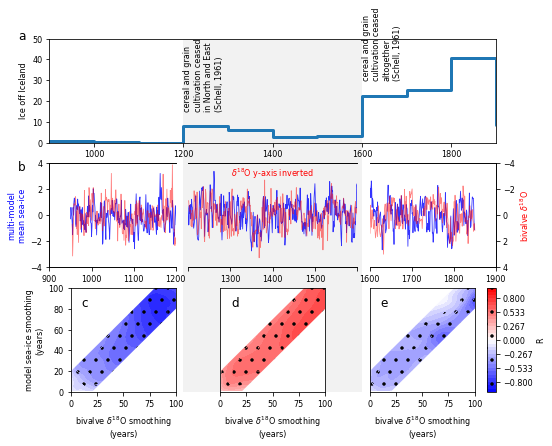

phase 1 correlation
-0.8233961763074253
phase 2 correlation
0.8046822514131075
phase 3 correlation
-0.7130699145467991


In [60]:
#####
# plotting
#####

my_linewidth = 0.8

plt.close('all')
fig = plt.figure(figsize = (8,6.5))

#plt1

ax1 = plt.subplot2grid((3,3),(0,0),rowspan=1,colspan=3)

bins = [900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900,1950]
x=[0.1,0.7,0.2,0.0,7.8,6.0,2.8,3.2,22.6,25.3,40.8,8.6] # duration of sea-ice (in weeks) * extend along N. Iceland coast
#not also https://www.jstor.org/tc/accept?origin=%2Fstable%2Fpdf%2F520132.pdf says cereal and grain cultivatoin ceased in north and east before end of 12 century, and altogether near end of 16th C
ax1.step(bins,x,lw=3)
ax1.set_ylabel('Ice off Iceland')
plt.text(1200, 32, 'cereal and grain\ncultivation ceased\nin North and East\n(Schell, 1961)', rotation=90)
plt.text(1600, 47, 'cereal and grain\ncultivation ceased\naltogether\n(Schell, 1961)', rotation=90)

ax1.set_xlim([900,1900])
ax1.set_ylim([0.0,50])

#plt 2
ax2 = plt.subplot2grid((3,42),(1,0),rowspan=1,colspan=12)

year2 = year[0]+np.arange(900)
# y = running_mean.running_mean(multimodel_mean-np.nanmean(multimodel_mean),1)
y = multimodel_mean-np.nanmean(multimodel_mean)
y /= np.std(y)
ax2.plot(year2,y,'b',linewidth = my_linewidth, alpha=0.8,label = 'multi-model mean sea-ice')
x_fill = np.concatenate([year2,np.flipud(year2)])
y_fill = np.concatenate([multimodel_min / np.std(y),np.flipud(multimodel_max) / np.std(y)])
# ax1.fill_between(x_fill,y_fill,edgecolor = 'none', facecolor='blue', alpha=0.2)

ax2b = ax2.twinx()
# loc = np.where((reynolds_data[:,0] <= 1850) & (reynolds_data[:,0] >= 850) )[0]
loc = np.where((reynolds_data[:,0] <= 1200) & (reynolds_data[:,0] >= 850) )[0]
y_reynolds = reynolds_data[loc[0]:loc[-1],2]
y_reynolds2 = signal.detrend(y_reynolds)
y_reynolds2 /= np.std(y_reynolds2)
ax2b.plot(reynolds_data[loc[0]:loc[-1],0],y_reynolds2,'r',linewidth = my_linewidth, alpha=0.5,label = 'bivalve $\delta^{18}$O')

ax2.set_ylabel('multi-model\nmean sea-ice')
ax2.yaxis.label.set_color('b')

# ax2b.set_ylabel('bivalve $\delta^{18}$O')
ax2b.set_xlim([900,1200])
ax2.set_ylim([-4.0,4.0])
ax2b.set_ylim([4.0,-4.0])
# ax2.plot([900,1850],[0,0],'k')
ax2b.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    labelright=False) # labels along the bottom edge are off

ax2.spines['right'].set_visible(False)
ax2b.spines['right'].set_visible(False)

#plt 2_right
ax2_right = plt.subplot2grid((3,42),(1,30),rowspan=1,colspan=12)

# y = running_mean.running_mean(multimodel_mean-np.nanmean(multimodel_mean),1)
y = multimodel_mean-np.nanmean(multimodel_mean)
y /= np.std(y)
ax2_right.plot(year2,y,'b',linewidth = my_linewidth, alpha=0.8,label = 'multi-model mean sea-ice')
x_fill = np.concatenate([year2,np.flipud(year2)])
y_fill = np.concatenate([multimodel_min / np.std(y),np.flipud(multimodel_max) / np.std(y)])
# ax1.fill_between(x_fill,y_fill,edgecolor = 'none', facecolor='blue', alpha=0.2)

ax2b_right = ax2_right.twinx()

loc = np.where((reynolds_data[:,0] <= 1850) & (reynolds_data[:,0] >= 1600) )[0]
y_reynolds = reynolds_data[loc[0]:loc[-1],2]
y_reynolds2 = signal.detrend(y_reynolds)
y_reynolds2 /= np.std(y_reynolds2)
ax2b_right.plot(reynolds_data[loc[0]:loc[-1],0],y_reynolds2,'r',linewidth = my_linewidth, alpha=0.5,label = 'bivalve $\delta^{18}$O')

# ax2_right.set_ylabel('sea-ice')
ax2b_right.set_ylabel('bivalve $\delta^{18}$O')
ax2b_right.yaxis.label.set_color('r')
ax2b_right.set_xlim([1600,1900])
ax2_right.set_ylim([-4.0,4.0])
ax2b_right.set_ylim([4.0,-4.0])
# ax2.plot([900,1850],[0,0],'k')
ax2_right.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False, # labels along the bottom edge are off
    right=True,      # ticks along the bottom edge are off
    labelright=False) # labels along the bottom edge are off
ax2b_right.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False, # labels along the bottom edge are off
    right=False,      # ticks along the bottom edge are off
    labelright=True) # labels along the bottom edge are off

ax2_right.spines['left'].set_visible(False)
ax2b_right.spines['left'].set_visible(False)


#plt 3
ax3 = plt.subplot2grid((3,42),(1,13),rowspan=1,colspan=16)
ax3.set_facecolor('none')

lab1 = ax3.plot(year2,y,'b',linewidth = my_linewidth, alpha=0.8,label = 'model mean Atl. ann mean sea-ice')
x_fill = np.concatenate([year2,np.flipud(year2)])
y_fill = np.concatenate([multimodel_min,np.flipud(multimodel_max)])
# ax1.fill_between(x_fill,y_fill,edgecolor = 'none', facecolor='blue', alpha=0.2)

ax3b = ax3.twinx()
# loc = np.where((reynolds_data[:,0] <= 1850) & (reynolds_data[:,0] >= 850) )[0]
loc = np.where((reynolds_data[:,0] <= 1600) & (reynolds_data[:,0] >= 1200) )[0]

y_reynolds = reynolds_data[loc[0]:loc[-1],2]
y_reynolds2 = signal.detrend(y_reynolds)
# y_reynolds2 = y_reynolds - np.nanmean(y_reynolds)

y_reynolds2 /= np.std(y_reynolds2)
lab2 = ax3b.plot(reynolds_data[loc[0]:loc[-1],0],y_reynolds2,'r',linewidth = my_linewidth, alpha=0.5,label = 'bivalve d18O')

# ax3.set_ylabel('sea-ice')
# ax3b.set_ylabel('bivalve $\delta^{18}$O')
ax3.set_xticklabels(['',1300,1400,1500,''])
ax3.set_xlim([1200,1600])
ax3.set_ylim([-4.0,4.0])
ax3b.set_ylim([-4.0,4.0])
# ax3.plot([900,1850],[0,0],'k')
ax3.set_xlabel('year')

ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False, # labels along the bottom edge are off
    right=False,      # ticks along the bottom edge are off
    labelright=False) # labels along the bottom edge are off
ax3b.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False, # labels along the bottom edge are off
    right=False,      # ticks along the bottom edge are off
    labelright=False) # labels along the bottom edge are off
ax3.spines['left'].set_visible(False)
ax3b.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3b.spines['right'].set_visible(False)

ax3.text(1400, 3, '$\delta^{18}$O y-axis inverted',horizontalalignment='center',color='r')

########


# plotting correlations #
import matplotlib.cm as mpl_cm

cmap1 = mpl_cm.get_cmap('bwr')
cmap2 = mpl_cm.get_cmap('bwr')


#plt 1
ax4 = plt.subplot2grid((3,42),(2,2),rowspan=1,colspan=10)

cont1 = ax4.contourf(smoothings1,smoothings2,phase1_corr_sig,np.linspace(-1,1,31),hatches=['.'],cmap=cmap1)
ax4.contourf(smoothings1,smoothings2,phase1_corr_not_sig,np.linspace(-1,1,31),cmap=cmap2)
ax4.fill_between([20,200,200,20],[0,0,180,0],edgecolor = 'none', facecolor='white', alpha=1.0)
ax4.fill_between([0,0,180,0],[20,200,200,20],edgecolor = 'none', facecolor='white', alpha=1.0)
ax4.set_xlim(0,100)
ax4.set_ylim(0,100)
ax4.set_xlabel('bivalve $\delta^{18}$O smoothing\n(years)')
ax4.set_ylabel('model sea-ice smoothing\n(years)')
# plt.colorbar(cont1)

#plt 2
ax5 = plt.subplot2grid((3,42),(2,16),rowspan=1,colspan=10)

cont1 = ax5.contourf(smoothings1,smoothings2,phase2_corr_sig,np.linspace(-1,1,31),hatches=['.'],cmap=cmap1)
ax5.contourf(smoothings1,smoothings2,phase2_corr_not_sig,np.linspace(-1,1,31),cmap=cmap2)
ax5.fill_between([20,200,200,20],[0,0,180,0],edgecolor = 'none', facecolor='white', alpha=1.0)
ax5.fill_between([0,0,180,0],[20,200,200,20],edgecolor = 'none', facecolor='white', alpha=1.0)
ax5.set_xlim(0,100)
ax5.set_ylim(0,100)
ax5.set_xlabel('bivalve $\delta^{18}$O smoothing\n(years)')
ax5.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    labelbottom=True, # labels along the bottom edge are off
    left=False,      # ticks along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off

#plt 3
ax6 = plt.subplot2grid((3,42),(2,30),rowspan=1,colspan=10)

cont1 = ax6.contourf(smoothings1,smoothings2,phase3_corr_sig,np.linspace(-1,1,31),hatches=['.'],cmap=cmap1)
ax6.contourf(smoothings1,smoothings2,phase3_corr_not_sig,np.linspace(-1,1,31),cmap=cmap2)
ax6.fill_between([20,200,200,20],[0,0,180,0],edgecolor = 'none', facecolor='white', alpha=1.0)
ax6.fill_between([0,0,180,0],[20,200,200,20],edgecolor = 'none', facecolor='white', alpha=1.0)
ax6.set_xlim(0,100)
ax6.set_ylim(0,100)
ax6.set_xlabel('bivalve $\delta^{18}$O smoothing\n(years)')
ax6.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    labelbottom=True, # labels along the bottom edge are off
    left=False,      # ticks along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off


####
# grey boxes
####
import matplotlib

from matplotlib.patches import Ellipse


ax1.add_patch(plt.Rectangle((1200,50),400, -170,facecolor='silver',
                              clip_on=False,linewidth = 0,alpha=0.2))


#####
# colorbar
#####


ax7 = plt.subplot2grid((3,42),(2,41),rowspan=1,colspan=1)
cb1 = plt.colorbar(cont1, cax=ax7,extend='both',orientation='vertical')
cb1.set_label('R')



plt.text(  # position text relative to Figure
    0.07, 0.9, 'a',
    ha='left', va='top',
    fontsize=12,
    transform=fig.transFigure)

plt.text(  # position text relative to Figure
    0.07, 0.62, 'b',
    ha='left', va='top',
    fontsize=12,
    transform=fig.transFigure)

plt.text(  # position text relative to Figure
    0.18, 0.33, 'c',
    ha='left', va='top',
    fontsize=12,
    transform=fig.transFigure)


plt.text(  # position text relative to Figure
    0.44, 0.33, 'd',
    ha='left', va='top',
    fontsize=12,
    transform=fig.transFigure)

plt.text(  # position text relative to Figure
    0.7, 0.33, 'e',
    ha='left', va='top',
    fontsize=12,
    transform=fig.transFigure)

plt.savefig('/home/ph290/Documents/figures/multi_model_mean_seaice_version2_ann_mean_with_correlations.png')
plt.savefig('/home/ph290/Documents/figures/multi_model_mean_seaice_version2_ann_mean_with_correlations.pdf')
plt.show(block = False)

print 'phase 1 correlation'
print np.nanmin(phase1_corr_sig)
print 'phase 2 correlation'
print np.nanmax(phase2_corr_sig)
print 'phase 3 correlation'
print np.nanmin(phase3_corr_sig)